In [1]:
!pip install tensorflow==1.6

    100% |████████████████████████████████| 45.9MB 741kB/s 
    100% |████████████████████████████████| 3.1MB 10.9MB/s 
    100% |████████████████████████████████| 890kB 11.8MB/s 
  Running setup.py bdist_wheel for html5lib ... - \ done
  Stored in directory: /root/.cache/pip/wheels/50/ae/f9/d2b189788efcf61d1ee0e36045476735c838898eef1cad6e29
Successfully built html5lib
  Found existing installation: bleach 3.0.2
    Uninstalling bleach-3.0.2:
      Successfully uninstalled bleach-3.0.2
  Found existing installation: tensorboard 1.12.0
    Uninstalling tensorboard-1.12.0:
      Successfully uninstalled tensorboard-1.12.0
  Found existing installation: tensorflow 1.12.0
    Uninstalling tensorflow-1.12.0:
      Successfully uninstalled tensorflow-1.12.0


In [2]:
!pip install edward

    100% |████████████████████████████████| 71kB 6.6MB/s 
  Running setup.py bdist_wheel for edward ... - \ done
  Stored in directory: /root/.cache/pip/wheels/ae/61/0c/1f36f3f0c629d1b7a24d042d2c37015a66c091729c95dd8425
Successfully built edward


In [0]:
from google.colab import auth
auth.authenticate_user()

In [6]:
# Install a Drive FUSE wrapper.
# https://github.com/astrada/google-drive-ocamlfuse
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package libfuse2:amd64.
(Reading database ... 22280 files and directories currently installed.)
Preparing to unpack .../libfuse2_2.9.7-1ubuntu1_amd64.deb ...
Unpacking libfuse2:amd64 (2.9.7-1ubuntu1) ...
Selecting previously unselected package fuse.
Preparing to unpack .../fuse_2.9.7-1ubuntu1_amd64.deb ...
Unpacking fuse (2.9.7-1ubuntu1) ...
Selecting previously unselected package google-drive-ocamlfuse.
Preparing to unpack .../google-drive-ocamlfuse_0.7.0-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.0-0ubuntu1~ubuntu18.04.1) ...
Setting up libfuse2:amd64 (2.9.7-1ubuntu1) ...
Processing triggers for libc-bin (2.27-3ubuntu1) ...
Setting up fuse (2.9.7-1ubuntu1) ...
Setting up google-drive-ocamlfuse (0.7.0-0ubuntu1~ubuntu18.04.1) ...


In [7]:
# Generate creds for the Drive FUSE library.
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

# Create a directory and mount Google Drive using that directory.
!mkdir -p drive
!google-drive-ocamlfuse drive

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


# First Run (raw data, no scaling)

In [0]:
import edward as ed
import pandas as pd
import numpy as np
import tensorflow as tf

In [0]:
csv = pd.read_csv('drive/player_season_stats.csv', index_col = 0)
csv = csv[csv.Year>=2011]
csv = csv.fillna(csv.mean())
count_columns = [col for col in csv.columns if not (('%' in col) or (col in ['PER', 'Age', 'OWS', 'DWS', 'WS', 'WS/48', 'BPM', 'VORP', '3PAr', 'FTr']))]
count_csv = csv[count_columns]
total_csv = csv.drop_duplicates(subset = ['Year', 'Player'], keep='first')[count_columns]

In [0]:
x_train = np.array(total_csv.drop(['Year', 'Player', 'Pos', 'Tm', 'MP'], axis=1))
N = x_train.shape[0]
D = x_train.shape[1]
K = 5

In [0]:
from edward.models import Dirichlet, InverseGamma, MultivariateNormalDiag, \
    Normal, ParamMixture, Empirical

#tf.reset_default_graph()

pi = Dirichlet(tf.ones(K))
mu = Normal(tf.zeros(D), tf.ones(D), sample_shape=K)
sigmasq = InverseGamma(tf.ones(D), tf.ones(D), sample_shape=K)
x = ParamMixture(pi, {'loc': mu, 'scale_diag': tf.sqrt(sigmasq)},
                 MultivariateNormalDiag,
                 sample_shape=N)
z = x.cat

In [16]:
T = 500  # number of MCMC samples

qpi = Empirical(tf.get_variable(
    "qpi/params", [T, K],
    initializer=tf.constant_initializer(1.0 / K)))
qmu = Empirical(tf.get_variable(
    "qmu/params", [T, K, D],
    initializer=tf.zeros_initializer()))
qsigmasq = Empirical(tf.get_variable(
    "qsigmasq/params", [T, K, D],
    initializer=tf.ones_initializer()))
qz = Empirical(tf.get_variable(
    "qz/params", [T, N],
    initializer=tf.zeros_initializer(),
    dtype=tf.int32))

ValueError: ignored

In [17]:
inference = ed.Gibbs({pi: qpi, mu: qmu, sigmasq: qsigmasq, z: qz},
                     data={x: x_train})
inference.initialize()

sess = ed.get_session()
tf.global_variables_initializer().run()

t_ph = tf.placeholder(tf.int32, [])
running_cluster_means = tf.reduce_mean(qmu.params[:t_ph], 0)

for _ in range(inference.n_iter):
  info_dict = inference.update()
  inference.print_progress(info_dict)
  t = info_dict['t']
  #if t % inference.n_print == 0:
  #  print("\nInferred cluster means:")
  #  print(sess.run(running_cluster_means, {t_ph: t - 1}))

/usr/local/lib/python3.6/dist-packages/edward/util/random_variables.py:52: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  not np.issubdtype(value.dtype, np.float) and \


500/500 [100%] ██████████████████████████████ Elapsed: 206s | Acceptance Rate: 1.000


In [0]:
cluster_means = sess.run(running_cluster_means, {t_ph: t - 1})

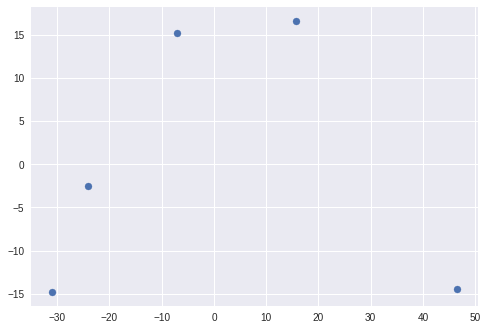

In [19]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca_model = PCA(n_components=2)
stats_transformed = pca_model.fit_transform(cluster_means)
plt.scatter(stats_transformed[:,0], stats_transformed[:, 1])

In [0]:
# Calculate likelihood for each data point and cluster assignment,
# averaged over many posterior samples. ``x_post`` has shape (N, 100, K, D).
mu_sample = qmu.sample(100)
sigmasq_sample = qsigmasq.sample(100)
x_post = Normal(loc=tf.cast(tf.ones([N, 1, 1, 1]) * mu_sample, tf.float64),
                scale=tf.cast(tf.ones([N, 1, 1, 1]) * tf.sqrt(sigmasq_sample), tf.float64))
x_broadcasted = tf.tile(tf.reshape(x_train, [N, 1, 1, D]), [1, 100, K, 1])

# Sum over latent dimension, then average over posterior samples.
# ``log_liks`` ends up with shape (N, K).
log_liks = x_post.log_prob(x_broadcasted)
log_liks = tf.reduce_sum(log_liks, 3)
log_liks = tf.reduce_mean(log_liks, 1)
#print(log_liks.shape)
#log_liks.eval()[:10]

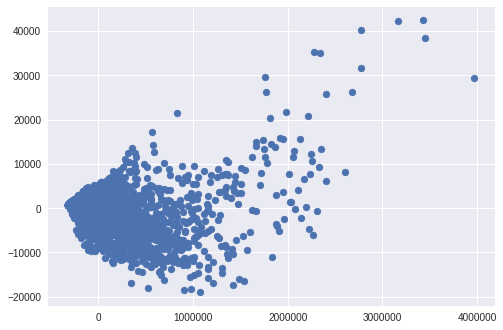

In [21]:
log_ll_values = sess.run(log_liks)

log_ll_values_2d = PCA(n_components=2).fit_transform(log_ll_values)
plt.scatter(log_ll_values_2d[:,0], log_ll_values_2d[:, 1])

In [22]:
from collections import Counter

clusters = tf.argmax(log_liks, 1).eval()

counts = Counter(clusters)
counts.most_common(5)

[(0, 1968), (1, 899), (2, 206), (3, 134), (4, 126)]

In [23]:
positions = total_csv['Pos'].tolist()
pos_clusters = pd.DataFrame(list(zip(positions, clusters)), columns=['Pos', 'Cluster'])
pos_clusters = pos_clusters[pos_clusters['Pos'].isin(['C', 'PF', 'PG', 'SF', 'SG'])]
print(pos_clusters.groupby(['Pos', 'Cluster']).size())


Pos  Cluster
C    0          383
     1          161
     2           42
     3           44
     4           30
PF   0          402
     1          177
     2           45
     3           24
     4           23
PG   0          386
     1          167
     2           30
     3           23
     4           20
SF   0          359
     1          198
     2           40
     3           21
     4           21
SG   0          411
     1          176
     2           49
     3           22
     4           31
dtype: int64


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  after removing the cwd from sys.path.


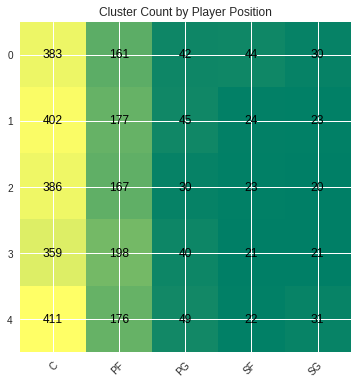

In [24]:
positions = ['C', 'PF', 'PG', 'SF', 'SG']
clusters = list(range(5))

pos_clusters_data = pos_clusters.groupby(['Pos', 'Cluster']).size().reshape([5, 5])


fig, ax = plt.subplots()
im = ax.imshow(pos_clusters_data, cmap = 'summer')

# We want to show all ticks...
ax.set_xticks(np.arange(len(positions)))
ax.set_yticks(np.arange(len(clusters)))
# ... and label them with the respective list entries
ax.set_xticklabels(positions)
ax.set_yticklabels(clusters)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(positions)):
    for j in range(len(clusters)):
        text = ax.text(j, i, pos_clusters_data[i, j],
                       ha="center", va="center", color="black")

ax.set_title("Cluster Count by Player Position")
fig.tight_layout()
plt.show()

#Second Run (scaling)

In [0]:
import edward as ed
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

In [0]:
csv = pd.read_csv('drive/player_season_stats.csv', index_col = 0)
csv = csv[csv.Year>=2011]
csv = csv.fillna(csv.mean())
count_columns = [col for col in csv.columns if not (('%' in col) or (col in ['PER', 'Age', 'OWS', 'DWS', 'WS', 'WS/48', 'BPM', 'VORP', '3PAr', 'FTr']))]
count_csv = csv[count_columns]
total_csv = csv.drop_duplicates(subset = ['Year', 'Player'], keep='first')[count_columns]

In [3]:
x_train = total_csv[total_csv['MP']!=0]

# Standardizing variance across stats
x_train = total_csv.drop(['Year', 'Player', 'Pos', 'Tm', 'MP'], axis=1)
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
print(x_train.shape)

N = x_train.shape[0]
D = x_train.shape[1]
K = 5

(3333, 19)


In [0]:
from edward.models import Dirichlet, InverseGamma, MultivariateNormalDiag, \
    Normal, ParamMixture, Empirical

#tf.reset_default_graph()

pi = Dirichlet(tf.ones(K))
mu = Normal(tf.zeros(D), tf.ones(D), sample_shape=K)
sigmasq = InverseGamma(tf.ones(D), tf.ones(D), sample_shape=K)
x = ParamMixture(pi, {'loc': mu, 'scale_diag': tf.sqrt(sigmasq)},
                 MultivariateNormalDiag,
                 sample_shape=N)
z = x.cat

In [0]:
T = 500  # number of MCMC samples

qpi = Empirical(tf.get_variable(
    "qpi/params", [T, K],
    initializer=tf.constant_initializer(1.0 / K)))
qmu = Empirical(tf.get_variable(
    "qmu/params", [T, K, D],
    initializer=tf.zeros_initializer()))
qsigmasq = Empirical(tf.get_variable(
    "qsigmasq/params", [T, K, D],
    initializer=tf.ones_initializer()))
qz = Empirical(tf.get_variable(
    "qz/params", [T, N],
    initializer=tf.zeros_initializer(),
    dtype=tf.int32))

In [6]:
inference = ed.Gibbs({pi: qpi, mu: qmu, sigmasq: qsigmasq, z: qz},
                     data={x: x_train})
inference.initialize()

sess = ed.get_session()
tf.global_variables_initializer().run()

t_ph = tf.placeholder(tf.int32, [])
running_cluster_means = tf.reduce_mean(qmu.params[:t_ph], 0)

for _ in range(inference.n_iter):
  info_dict = inference.update()
  inference.print_progress(info_dict)
  t = info_dict['t']
  #if t % inference.n_print == 0:
  #  print("\nInferred cluster means:")
  #  print(sess.run(running_cluster_means, {t_ph: t - 1}))

/usr/local/lib/python3.6/dist-packages/edward/util/random_variables.py:52: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  not np.issubdtype(value.dtype, np.float) and \


500/500 [100%] ██████████████████████████████ Elapsed: 205s | Acceptance Rate: 1.000


In [0]:
cluster_means = sess.run(running_cluster_means, {t_ph: t - 1})

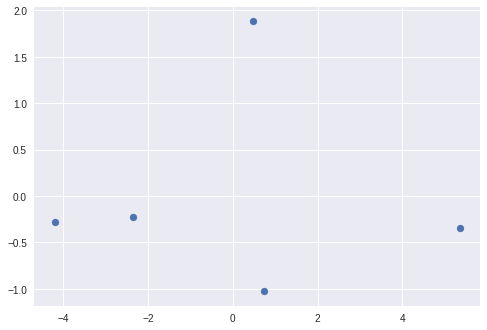

In [8]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca_model = PCA(n_components=2)
stats_transformed = pca_model.fit_transform(cluster_means)
plt.scatter(stats_transformed[:,0], stats_transformed[:, 1])

In [0]:
# Calculate likelihood for each data point and cluster assignment,
# averaged over many posterior samples. ``x_post`` has shape (N, 100, K, D).
mu_sample = qmu.sample(100)
sigmasq_sample = qsigmasq.sample(100)
x_post = Normal(loc=tf.cast(tf.ones([N, 1, 1, 1]) * mu_sample, tf.float64),
                scale=tf.cast(tf.ones([N, 1, 1, 1]) * tf.sqrt(sigmasq_sample), tf.float64))
x_broadcasted = tf.tile(tf.reshape(x_train, [N, 1, 1, D]), [1, 100, K, 1])

# Sum over latent dimension, then average over posterior samples.
# ``log_liks`` ends up with shape (N, K).
log_liks = x_post.log_prob(x_broadcasted)
log_liks = tf.reduce_sum(log_liks, 3)
log_liks = tf.reduce_mean(log_liks, 1)
#print(log_liks.shape)
#log_liks.eval()[:10]

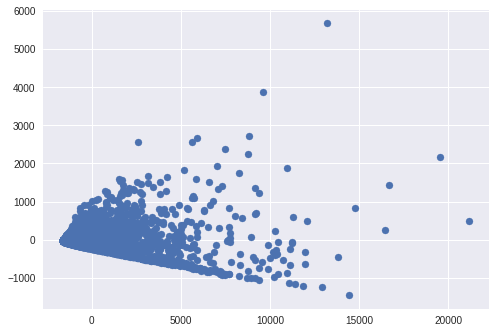

In [10]:
log_ll_values = sess.run(log_liks)

log_ll_values_2d = PCA(n_components=2).fit_transform(log_ll_values)
plt.scatter(log_ll_values_2d[:,0], log_ll_values_2d[:, 1])

In [11]:
from collections import Counter

clusters = tf.argmax(log_liks, 1).eval()

counts = Counter(clusters)
counts.most_common(5)

[(2, 832), (4, 770), (3, 720), (0, 688), (1, 323)]

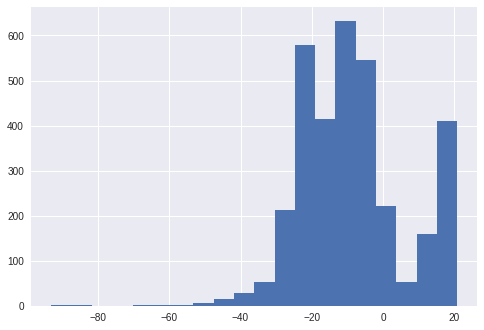

In [12]:
max_log_liks = np.max(log_liks.eval(), 1)

plt.hist(max_log_liks, bins=20)
plt.show()

In [13]:
csv.head()

,Year,Player,Pos,Age,Tm,G,GS,MP,PER,TS%,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
20501,2011.0,Jeff Adrien,PF,24.0,GSW,23.0,0.0,196.0,11.3,0.457,...,0.579000,23.0,35.0,58.0,10.0,4.0,5.0,9.0,28.0,57.0
20502,2011.0,Arron Afflalo,SG,25.0,DEN,69.0,69.0,2324.0,13.6,0.620,...,0.847000,45.0,206.0,251.0,168.0,34.0,31.0,71.0,153.0,867.0
20503,2011.0,Maurice Ager,SG,26.0,MIN,4.0,0.0,29.0,10.1,0.682,...,0.723489,0.0,2.0,2.0,1.0,1.0,0.0,4.0,4.0,15.0
20504,2011.0,Alexis Ajinca,C,22.0,TOT,34.0,2.0,340.0,12.2,0.507,...,0.722000,17.0,61.0,78.0,10.0,11.0,19.0,18.0,73.0,143.0
20505,2011.0,Alexis Ajinca,C,22.0,DAL,10.0,2.0,75.0,12.8,0.435,...,0.667000,5.0,12.0,17.0,2.0,3.0,5.0,1.0,13.0,29.0


In [14]:
positions = total_csv['Pos'].tolist()
pos_clusters = pd.DataFrame(list(zip(positions, clusters)), columns=['Pos', 'Cluster'])
pos_clusters = pos_clusters[pos_clusters['Pos'].isin(['C', 'PF', 'PG', 'SF', 'SG'])]
print(pos_clusters.groupby(['Pos', 'Cluster']).size())


Pos  Cluster
C    0          146
     1          200
     2           26
     3          131
     4          157
PF   0          132
     1          118
     2          103
     3          141
     4          177
PG   0          116
     2          214
     3          137
     4          159
SF   0          139
     1            4
     2          212
     3          151
     4          133
SG   0          145
     2          260
     3          147
     4          137
dtype: int64


In [15]:
positions = ['C', 'PF', 'PG', 'SF', 'SG']
clusters = list(range(5))

pos_clusters_data = pos_clusters.groupby(['Pos', 'Cluster']).size().reshape([5, 5])


fig, ax = plt.subplots()
im = ax.imshow(pos_clusters_data, cmap = 'summer')

# We want to show all ticks...
ax.set_xticks(np.arange(len(positions)))
ax.set_yticks(np.arange(len(clusters)))
# ... and label them with the respective list entries
ax.set_xticklabels(positions)
ax.set_yticklabels(clusters)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(positions)):
    for j in range(len(clusters)):
        text = ax.text(j, i, pos_clusters_data[i, j],
                       ha="center", va="center", color="black")

ax.set_title("Cluster Count by Player Position")
fig.tight_layout()
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  after removing the cwd from sys.path.


ValueError: ignored

# Third Run (scaling & per-minute stats)

In [0]:
import edward as ed
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

In [0]:
csv = pd.read_csv('drive/player_season_stats.csv', index_col = 0)
csv = csv[csv.Year>=2011]
csv = csv.fillna(csv.mean())
count_columns = [col for col in csv.columns if not (('%' in col) or (col in ['PER', 'Age', 'OWS', 'DWS', 'WS', 'WS/48', 'BPM', 'VORP', '3PAr', 'FTr']))]
count_csv = csv[count_columns]
total_csv = csv.drop_duplicates(subset = ['Year', 'Player'], keep='first')[count_columns]

In [4]:
x_train = total_csv[total_csv['MP']!=0]

for i in ['FG', 'FGA', '3P', '3PA', '2P', '2PA', 'FT', 'FTA',
       'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS']:
  x_train[i] = x_train[i].values / x_train['MP'].values


# Standardizing variance across stats
x_train = total_csv.drop(['Year', 'Player', 'Pos', 'Tm', 'MP'], axis=1)
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
print(x_train.shape)

N = x_train.shape[0]
D = x_train.shape[1]
K = 5

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


(3333, 19)


In [0]:
from edward.models import Dirichlet, InverseGamma, MultivariateNormalDiag, \
    Normal, ParamMixture, Empirical

#tf.reset_default_graph()

pi = Dirichlet(tf.ones(K))
mu = Normal(tf.zeros(D), tf.ones(D), sample_shape=K)
sigmasq = InverseGamma(tf.ones(D), tf.ones(D), sample_shape=K)
x = ParamMixture(pi, {'loc': mu, 'scale_diag': tf.sqrt(sigmasq)},
                 MultivariateNormalDiag,
                 sample_shape=N)
z = x.cat

In [0]:
T = 500  # number of MCMC samples

qpi = Empirical(tf.get_variable(
    "qpi/params", [T, K],
    initializer=tf.constant_initializer(1.0 / K)))
qmu = Empirical(tf.get_variable(
    "qmu/params", [T, K, D],
    initializer=tf.zeros_initializer()))
qsigmasq = Empirical(tf.get_variable(
    "qsigmasq/params", [T, K, D],
    initializer=tf.ones_initializer()))
qz = Empirical(tf.get_variable(
    "qz/params", [T, N],
    initializer=tf.zeros_initializer(),
    dtype=tf.int32))

In [7]:
inference = ed.Gibbs({pi: qpi, mu: qmu, sigmasq: qsigmasq, z: qz},
                     data={x: x_train})
inference.initialize()

sess = ed.get_session()
tf.global_variables_initializer().run()

t_ph = tf.placeholder(tf.int32, [])
running_cluster_means = tf.reduce_mean(qmu.params[:t_ph], 0)

for _ in range(inference.n_iter):
  info_dict = inference.update()
  inference.print_progress(info_dict)
  t = info_dict['t']
  #if t % inference.n_print == 0:
  #  print("\nInferred cluster means:")
  #  print(sess.run(running_cluster_means, {t_ph: t - 1}))

/usr/local/lib/python3.6/dist-packages/edward/util/random_variables.py:52: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  not np.issubdtype(value.dtype, np.float) and \


500/500 [100%] ██████████████████████████████ Elapsed: 204s | Acceptance Rate: 1.000


In [0]:
cluster_means = sess.run(running_cluster_means, {t_ph: t - 1})

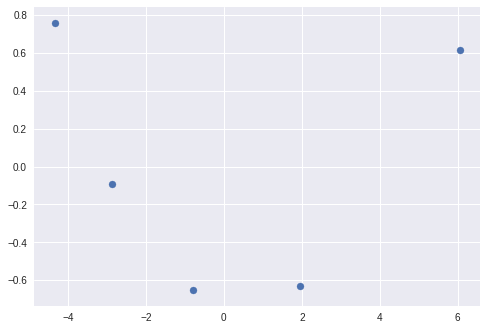

In [9]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca_model = PCA(n_components=2)
stats_transformed = pca_model.fit_transform(cluster_means)
plt.scatter(stats_transformed[:,0], stats_transformed[:, 1])

In [0]:
# Calculate likelihood for each data point and cluster assignment,
# averaged over many posterior samples. ``x_post`` has shape (N, 100, K, D).
mu_sample = qmu.sample(100)
sigmasq_sample = qsigmasq.sample(100)
x_post = Normal(loc=tf.cast(tf.ones([N, 1, 1, 1]) * mu_sample, tf.float64),
                scale=tf.cast(tf.ones([N, 1, 1, 1]) * tf.sqrt(sigmasq_sample), tf.float64))
x_broadcasted = tf.tile(tf.reshape(x_train, [N, 1, 1, D]), [1, 100, K, 1])

# Sum over latent dimension, then average over posterior samples.
# ``log_liks`` ends up with shape (N, K).
log_liks = x_post.log_prob(x_broadcasted)
log_liks = tf.reduce_sum(log_liks, 3)
log_liks = tf.reduce_mean(log_liks, 1)
#print(log_liks.shape)
#log_liks.eval()[:10]

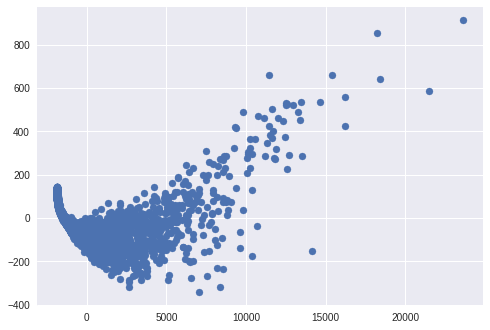

In [11]:
log_ll_values = sess.run(log_liks)

log_ll_values_2d = PCA(n_components=2).fit_transform(log_ll_values)
plt.scatter(log_ll_values_2d[:,0], log_ll_values_2d[:, 1])

In [12]:
from collections import Counter

clusters = tf.argmax(log_liks, 1).eval()

counts = Counter(clusters)
counts.most_common(5)

[(0, 819), (2, 752), (3, 617), (1, 606), (4, 539)]

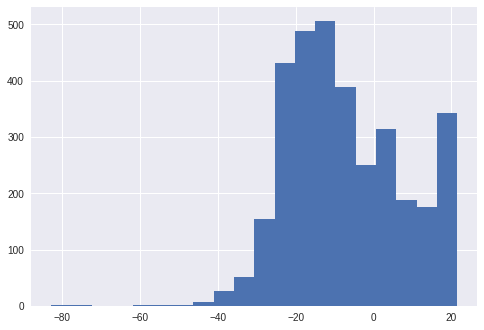

In [13]:
max_log_liks = np.max(log_liks.eval(), 1)

plt.hist(max_log_liks, bins=20)
plt.show()

In [14]:
csv.head()

,Year,Player,Pos,Age,Tm,G,GS,MP,PER,TS%,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
20501,2011.0,Jeff Adrien,PF,24.0,GSW,23.0,0.0,196.0,11.3,0.457,...,0.579000,23.0,35.0,58.0,10.0,4.0,5.0,9.0,28.0,57.0
20502,2011.0,Arron Afflalo,SG,25.0,DEN,69.0,69.0,2324.0,13.6,0.620,...,0.847000,45.0,206.0,251.0,168.0,34.0,31.0,71.0,153.0,867.0
20503,2011.0,Maurice Ager,SG,26.0,MIN,4.0,0.0,29.0,10.1,0.682,...,0.723489,0.0,2.0,2.0,1.0,1.0,0.0,4.0,4.0,15.0
20504,2011.0,Alexis Ajinca,C,22.0,TOT,34.0,2.0,340.0,12.2,0.507,...,0.722000,17.0,61.0,78.0,10.0,11.0,19.0,18.0,73.0,143.0
20505,2011.0,Alexis Ajinca,C,22.0,DAL,10.0,2.0,75.0,12.8,0.435,...,0.667000,5.0,12.0,17.0,2.0,3.0,5.0,1.0,13.0,29.0


In [15]:
positions = total_csv['Pos'].tolist()
pos_clusters = pd.DataFrame(list(zip(positions, clusters)), columns=['Pos', 'Cluster'])
pos_clusters = pos_clusters[pos_clusters['Pos'].isin(['C', 'PF', 'PG', 'SF', 'SG'])]
print(pos_clusters.groupby(['Pos', 'Cluster']).size())


Pos  Cluster
C    0          135
     1          123
     2          146
     3          134
     4          122
PF   0          155
     1          111
     2          162
     3          123
     4          120
PG   0          159
     1          112
     2          134
     3           99
     4          122
SF   0          155
     1          133
     2          151
     3          120
     4           80
SG   0          202
     1          116
     2          147
     3          133
     4           91
dtype: int64


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  after removing the cwd from sys.path.


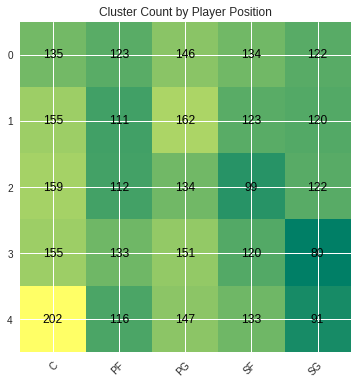

In [16]:
positions = ['C', 'PF', 'PG', 'SF', 'SG']
clusters = list(range(5))

pos_clusters_data = pos_clusters.groupby(['Pos', 'Cluster']).size().reshape([5, 5])


fig, ax = plt.subplots()
im = ax.imshow(pos_clusters_data, cmap = 'summer')

# We want to show all ticks...
ax.set_xticks(np.arange(len(positions)))
ax.set_yticks(np.arange(len(clusters)))
# ... and label them with the respective list entries
ax.set_xticklabels(positions)
ax.set_yticklabels(clusters)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(positions)):
    for j in range(len(clusters)):
        text = ax.text(j, i, pos_clusters_data[i, j],
                       ha="center", va="center", color="black")

ax.set_title("Cluster Count by Player Position")
fig.tight_layout()
plt.show()

 # Poisson

Restart kernel and start from here for the next iteration of Box's loop

In [0]:
import edward as ed
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

In [0]:
csv = pd.read_csv('drive/player_season_stats.csv', index_col = 0)
csv = csv[csv.Year>=2011]
csv = csv.fillna(csv.mean())
count_columns = [col for col in csv.columns if not (('%' in col) or (col in ['PER', 'Age', 'OWS', 'DWS', 'WS', 'WS/48', 'BPM', 'VORP', '3PAr', 'FTr']))]
count_csv = csv[count_columns]
total_csv = csv.drop_duplicates(subset = ['Year', 'Player'], keep='first')[count_columns]

In [6]:
x_train = total_csv[total_csv['MP']!=0]
N = x_train.shape[0]
D = x_train.shape[1]
K = 5
x_train.columns

Index(['Year', 'Player', 'Pos', 'Tm', 'G', 'GS', 'MP', 'FG', 'FGA', '3P',
       '3PA', '2P', '2PA', 'FT', 'FTA', 'ORB', 'DRB', 'TRB', 'AST', 'STL',
       'BLK', 'TOV', 'PF', 'PTS'],
      dtype='object')

In [0]:
#Redefine model here to use Poissons and multivariate normals
from edward.models import Dirichlet, InverseGamma, MultivariateNormalDiag, \
    Normal, ParamMixture, Empirical, Poisson, Independent

#tf.reset_default_graph()

x_pois_data = x_train[['ORB', 'DRB', 'AST', 'STL', 'BLK']]

x_norm_data = x_train[['G', 'GS', 'MP', 'FG', 'FGA', '3P',
       '3PA', '2P', '2PA', 'FT', 'FTA', 'TOV', 'PF', 'PTS']]

d_normal = x_norm_data.shape[1]
d_poisson = x_pois_data.shape[1]

pi = Dirichlet(tf.ones(K))
mu_normal = Normal(tf.zeros(d_normal), tf.ones(d_normal), sample_shape=K)
sigmasq_normal = InverseGamma(tf.ones(d_normal), tf.ones(d_normal), sample_shape=K)

rate_poisson = InverseGamma(tf.zeros(d_poisson), tf.ones(d_poisson), sample_shape=K)

x_normal = ParamMixture(pi, {'loc': mu_normal, 'scale_diag': tf.sqrt(sigmasq_normal)},
                        MultivariateNormalDiag,
                        sample_shape=N)
z = x.cat

# Attempt at mixture of MV poissons



qpi = Empirical(tf.get_variable(
    "qpi/params", [T, K],
    initializer=tf.constant_initializer(1.0 / K)))
qmu = Empirical(tf.get_variable(
    "qmu/params", [T, K, D],
    initializer=tf.zeros_initializer()))
qsigmasq = Empirical(tf.get_variable(
    "qsigmasq/params", [T, K, D],
    initializer=tf.ones_initializer()))
qz = Empirical(tf.get_variable(
    "qz/params", [T, N],
    initializer=tf.zeros_initializer(),
    dtype=tf.int32))

